In [1]:
%matplotlib inline

In [15]:
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import *
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension

from IPython.display import clear_output

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit import BasicAer, Aer
from qiskit.circuit import QuantumCircuit

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC

from time import time
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt

In [2]:
def read_data(datafile, labelindex):
    data_file = open(datafile)
    datalines = data_file.readlines()
    database = []
    labels = []
    all_labels = set()
    for data in datalines[1:]:
        feature_vector = list(data.strip().split(","))
        try:
            database.append(list(map(float, feature_vector[:labelindex] + feature_vector[labelindex+1:])))
        except:
            continue
        if feature_vector[labelindex] == "0":
            feature_vector[labelindex] = "0"
        elif feature_vector[labelindex] == "1":
            feature_vector[labelindex] = "1"
        else:
            feature_vector[labelindex] = "2"
        labels.append(feature_vector[labelindex])
        all_labels.add(feature_vector[labelindex])
    label_encodings = {d:i for i,d in enumerate(all_labels)}
    encoded_labels = [label_encodings[label] for label in labels]
    return np.array(database), np.array(encoded_labels)

In [164]:
def toy_data(set_num):
    dsize = 300
    x = np.random.random(dsize)
    y = np.random.random(dsize)    

    if set_num == 0:
        database = list(zip(x,y))
        labels = [0 if x[i] > y[i] else 1 for i in range(dsize)]
        x1 = []
        y1 = []
        x2 = []
        y2 = []
        for i in range(dsize):
            if labels[i] == 0:
                x1.append(x[i])
                y1.append(y[i])
            else:
                x2.append(x[i])
                y2.append(y[i])
        plt.figure(figsize=(6,4))
        plt.scatter(x1, y1, color='r', label='Class 0')
        plt.scatter(x2, y2, color='b', label='Class 1')
        plt.title('Dataset 0')
        plt.legend(bbox_to_anchor = (1.25, 0.5), loc='center right')
        plt.savefig("Figures/data_0", bbox_inches='tight')

    elif set_num == 1:
        database = list(zip(x, y))
        labels = [0 if (x[i]- 0.5)**2 + (y[i]-0.5)**2 < 0.1225 else 1 for i in range(dsize)]       

        x1 = []
        y1 = []
        x2 = []
        y2 = []
        for i in range(dsize):
            if labels[i] == 0:
                x1.append(x[i])
                y1.append(y[i])
            else:
                x2.append(x[i])
                y2.append(y[i])
        plt.figure(figsize=(6,5))
        plt.scatter(x1, y1, color='r', label='Class 0')
        plt.scatter(x2, y2, color='b', label='Class 1')
        plt.title('Dataset 1')
        plt.legend(bbox_to_anchor = (1.25, 0.5), loc='center right')
        plt.savefig("Figures/data_1", bbox_inches='tight')
        plt.show()
    
    elif set_num == 2:
        database = list(zip(x, y))
        labels = [0 if np.sin(x[i])*np.sin(y[i]) < 0.1 or np.sin(x[i])*np.sin(y[i]) > 0.3 else 1 for i in range(dsize)]   

        x1 = []
        y1 = []
        x2 = []
        y2 = []
        for i in range(dsize):
            if labels[i] == 0:
                x1.append(x[i])
                y1.append(y[i])
            else:
                x2.append(x[i])
                y2.append(y[i])
        plt.figure(figsize=(6,5))
        plt.scatter(x1, y1, color='r', label='Class 0')
        plt.scatter(x2, y2, color='b', label='Class 1')
        plt.title('Dataset 2')
        plt.legend(bbox_to_anchor = (1.25, 0.5), loc='center right')
        plt.savefig("Figures/data_2", bbox_inches='tight')
        plt.show()
    
    elif set_num == 3:
        z = np.random.random(dsize)
        database = list(zip(x, y, z))
        labels = [0 if x[i]*y[i] + z[i] > 0.5 else 1 for i in range(dsize)]   
    
    elif set_num == 4:
        z = np.random.random(dsize)
        w = np.random.random(dsize)
        database = list(zip(x, y, z, w))
        labels = [0 if x[i]*y[i] + z[i]*w[i] > 0.5 else 1 for i in range(dsize)]   
    
    else:
        print("Error: Incorrect number")
        return

    return np.array(database), np.array(labels)

In [4]:
class classify:        
    def __init__(self, datafile=None, labelindex=None, amp_encoded=False, toy=False):
        if datafile:
            self.database, self.labels = read_data(datafile, labelindex)
        else:
            self.database, self.labels = toy_data(toy)
        self.feature_dim = self.database.shape[1]
        self.amp_encoded = amp_encoded
        if self.amp_encoded:
            nq = int(np.ceil(np.log2(self.feature_dim)))
            self.database= np.pad(self.database, ((0,0),(0,2**nq - self.feature_dim)), mode="constant", constant_values=0)
            self.feature_dim = nq
        self.classifier = None
        self.ct = None
    
    def split(self, train_size=0.8, random_state=42):
        return train_test_split(self.database, self.labels, train_size=train_size, random_state=random_state)
    
    def kernel_qsvc(self, feature_map=None, seed=1376):
        if feature_map is None:
            feature_map = ZFeatureMap(self.feature_dim)

        kernel = QuantumKernel(feature_map=feature_map,
                                    quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                                    shots=1,
                                                    seed_simulator=seed,
                                                    seed_transpiler=seed))

        # print("Feature Map : ", kernel.feature_map.decompose())
        # print("Kernel matrix : ", kernel.evaluate(self.database, self.labels))
        self.classifier = QSVC(quantum_kernel=kernel)
        self.ct = 'qsvc'
    
    def kernel_qnn(self, feature_map=None, seed=1376):
        if feature_map is None:
            feature_map = ZFeatureMap(self.feature_dim)
        
        ansatz = RealAmplitudes(num_qubits=self.feature_dim, reps=1)
        qbase = QuantumCircuit(self.feature_dim)
        qbase.compose(feature_map, inplace=True)
        qbase.compose(ansatz, inplace=True)

        print("Initiating Qiskit Runtime Service...", end=" ")
        service = QiskitRuntimeService(
            channel='ibm_quantum',
            instance='ibm-q/open/main',
        )
        print("Qiskit Runtime Service initiated")
        print("Assigning backend...", end=" ")
        backend = service.backend('simulator_statevector')
        sampler = Sampler(session=backend)
        print("Backend assigned")

        def parity(x):
            return "{:b}".format(x).count("1") % 2
        output_shape = 2

        qnet = SamplerQNN(circuit=qbase, input_params=feature_map.parameters, weight_params=ansatz.parameters, interpret=parity, output_shape=output_shape, sampler=sampler)
        display(qnet.circuit.decompose().draw('mpl'))

        def callback_graph(weights, obj_func_eval):
            clear_output(wait=True)
            objective_func_vals.append(obj_func_eval)
            plt.title("Objective function value against iteration")
            plt.xlabel("Iteration")
            plt.ylabel("Objective function value")
            plt.plot(range(len(objective_func_vals)), objective_func_vals)
            plt.show()

        self.classifier = NeuralNetworkClassifier(neural_network=qnet, optimizer=COBYLA(maxiter=50), callback=callback_graph)        
        self.ct = 'qnn'

    def csvc(self, kernel="rbf", gamma="scale", seed=1376):
        csvc1 = SVC(kernel=kernel, gamma=gamma, random_state=seed)
        self.classifier = csvc1

    def train(self, train_data, train_labels):
        start = time()
        self.classifier.fit(train_data, train_labels)
        end = time()
        if self.ct == 'qnn':
            return end-start, self.classifier.weights
        return end-start
    
    def predict(self, test_data):
        start = time()
        pred_labels = self.classifier.predict(test_data)
        end = time()
        return pred_labels, end-start
    
    def get_scores(self, test_labels, pred_labels):
        acc =  accuracy_score(test_labels, pred_labels)
        prec = precision_score(test_labels, pred_labels, average="macro")
        recall = recall_score(test_labels, pred_labels, average="macro")
        f1 = f1_score(test_labels, pred_labels, average="macro")

        print("Accuracy: ", acc)
        print("Precision: ", prec)
        print("Recall: ", recall)
        print("F1: ", f1)
        print()

        return acc, prec, recall, f1

## Kernels

In [5]:
def eq_8(x):
    # for k = 1
    phi = x[0]
    return (np.pi/2)*phi

def eq_8_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else x[0]*x[1]
    return (np.pi/2)*phi

def eq_8_3(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else x[0]*x[1]*x[2]
    return (np.pi/2)*phi

In [6]:
def eq_9(x):
    # for k = 1
    phi = 1 - x[0]
    return (np.pi/2)*phi

def eq_9_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else (1-x[0])*(1-x[1])
    return (np.pi/2)*phi

def eq_9_2(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else (1-x[0])*(1-x[1])*(1-x[2])
    return (np.pi/2)*phi

In [7]:
def eq_10(x):
    # for k = 1
    phi = np.exp(np.square(x[0])/8)
    return np.pi*phi

def eq_10_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else np.exp(np.square(x[0] - x[1])/8)
    return np.pi*phi

def eq_10_2(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else np.exp(np.square(x[0] - x[1])/8) + np.exp(np.square(x[1] - x[2])/8) + np.exp(np.square(x[2] - x[0])/8)
    return np.pi*phi

In [8]:
def eq_11(x):
    # for k = 1
    phi = 1/np.cos(x[0])
    return (np.pi/3)*phi

def eq_11_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else 1/np.cos(x[0])*1/np.cos(x[1])
    return (np.pi/3)*phi

def eq_11_2(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else 1/np.cos(x[0])*1/np.cos(x[1])*1/np.cos(x[2])
    return (np.pi/3)*phi

In [9]:
def eq_12(x):
    # for k = 1
    phi = np.cos(x[0])
    return np.pi*phi

def eq_12_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else np.cos(x[0])*np.cos(x[1])
    return np.pi*phi

def eq_12_2(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else np.cos(x[0])*np.cos(x[1])*np.cos(x[2])
    return np.pi*phi

## CNN

In [163]:
from sklearn.neural_network import MLPClassifier

cnn_acc = []
for i in range(5):
    sc = 0
    X, y = toy_data(i)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X, y)
    cnn_acc.append(clf.score(X, y))
print(cnn_acc)

[1.0, 0.7133333333333334, 0.85, 0.95, 0.96]


## QNN

In [93]:
def qnn_encoding(paulis, func=None, datafile=None, dim=None, write_scores=False, toy=False):
    if datafile:
        folder = datafile[0]
        qc = classify(datafile, dim, False, False)
    else:
        folder = "T" + str(toy)
        qc = classify(None, None, False, toy)
    
    # train_data, test_data, train_labels, test_labels = qc.split()
    train_data = qc.database
    train_labels = qc.labels
    test_data = qc.database
    test_labels = qc.labels

    if func:
        fm = PauliFeatureMap(qc.feature_dim, data_map_func=func, paulis=paulis)
        qc.kernel_qnn(feature_map=fm)
    else:
        fm = PauliFeatureMap(qc.feature_dim, paulis=paulis)
        qc.kernel_qnn()
    print()

    print("Training...", end=" ")
    traintime, wts = qc.train(train_data, train_labels)
    print("Training complete. Training time: ", traintime)
    print("Testing...", end=" ")
    pred_labels, testime = qc.predict(test_data)
    print(confusion_matrix(test_labels, pred_labels))
    print("Testing complete. Testing time: ", testime)
    score = qc.get_scores(test_labels, pred_labels)

    if write_scores:
        af = open(f"{folder}/Acc.txt", "a")
        af.write(f"{score[0]}, ")
        af.close()

        pf = open(f"{folder}/Prec.txt", "a")
        pf.write(f"{score[1]}, ")
        pf.close()

        rf = open(f"{folder}/Rec.txt", "a")
        rf.write(f"{score[2]}, ")
        rf.close()

        ff = open(f"{folder}/F1.txt", "a")
        ff.write(f"{score[3]}, ")
        ff.close()

        trainf = open(f"{folder}/TrainTime.txt", "a")
        trainf.write(f"{traintime}, ")
        trainf.close()

        testf = open(f"{folder}/TestTime.txt", "a")
        testf.write(f"{testime}, ")
        testf.close()
    return wts, qc.classifier, qc.database

In [12]:
def qnn_ged(wts, nnc, dataset, toy):
    global_ed = EffectiveDimension(qnn=nnc.neural_network, weight_samples=len(wts), input_samples=10)
    global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=len(dataset))
    print("Data size: {}, global effective dimension: {:.4f}".format(len(dataset), global_eff_dim_0))
    d = nnc.neural_network.num_weights
    print("Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d))
    ff = open(f"T{toy}/ged.txt", "a")
    ff.write(f"{global_eff_dim_0/d}, ")
    ff.close()

In [13]:
def qnn_led(wts, nnc, dataset, toy):
    local_ed_trained = LocalEffectiveDimension(qnn=nnc.neural_network, weight_samples=wts, input_samples=dataset)
    local_eff_dim_trained = local_ed_trained.get_effective_dimension(dataset_size=len(dataset[0]))
    d = nnc.neural_network.num_weights
    print("Normalized local effective dimensions for trained QNN: ",  local_eff_dim_trained / d)
    ff = open(f"T{toy}/led.txt", "a")
    ff.write(f"{local_eff_dim_trained / d}, ")
    ff.close()

## Toy data 0

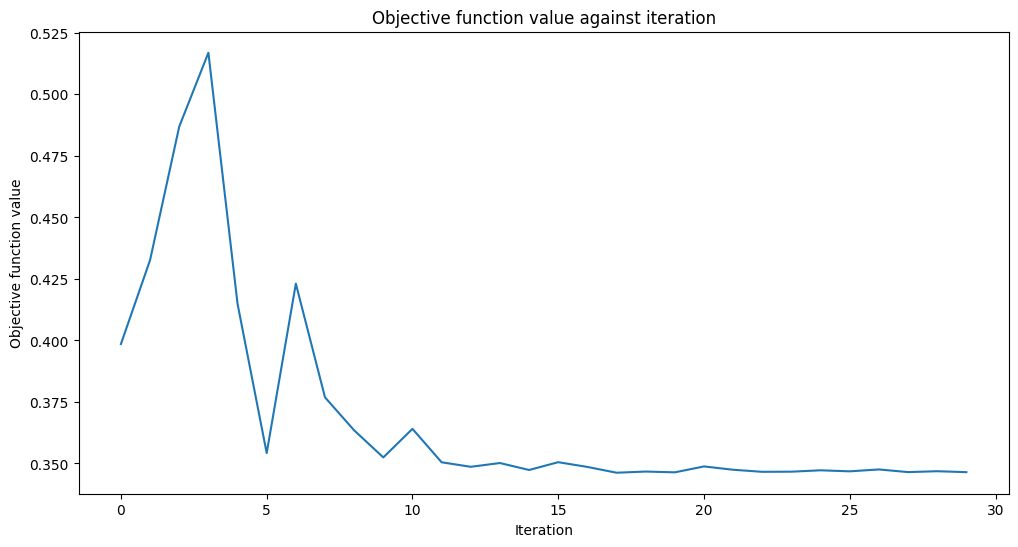

Training complete. Training time:  359.06676983833313
Testing... [[121  33]
 [ 38 108]]
Testing complete. Testing time:  10.974912166595459
Accuracy:  0.7633333333333333
Precision:  0.7634818680583434
Recall:  0.762720156555773
F1:  0.7628880898576215



In [154]:
objective_func_vals = []
toy = 0
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_8_1, toy=toy, write_scores=True)

In [155]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.6205
Number of weights: 4, normalized effective dimension: 0.9051
Normalized local effective dimensions for trained QNN:  -0.4327659897076332


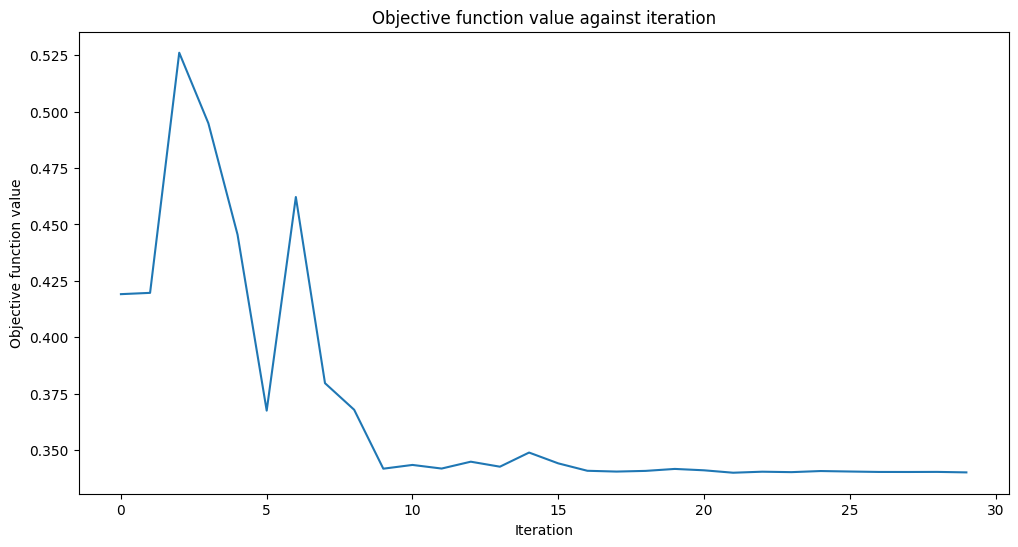

Training complete. Training time:  348.21724343299866
Testing... [[111  29]
 [ 55 105]]
Testing complete. Testing time:  10.45652723312378
Accuracy:  0.72
Precision:  0.7261283941737098
Recall:  0.7245535714285714
F1:  0.7198879551820727



In [156]:
objective_func_vals = []
toy = 0
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_9_1, toy=toy, write_scores=True)

In [157]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.5154
Number of weights: 4, normalized effective dimension: 0.8789
Normalized local effective dimensions for trained QNN:  -0.42600412070059573


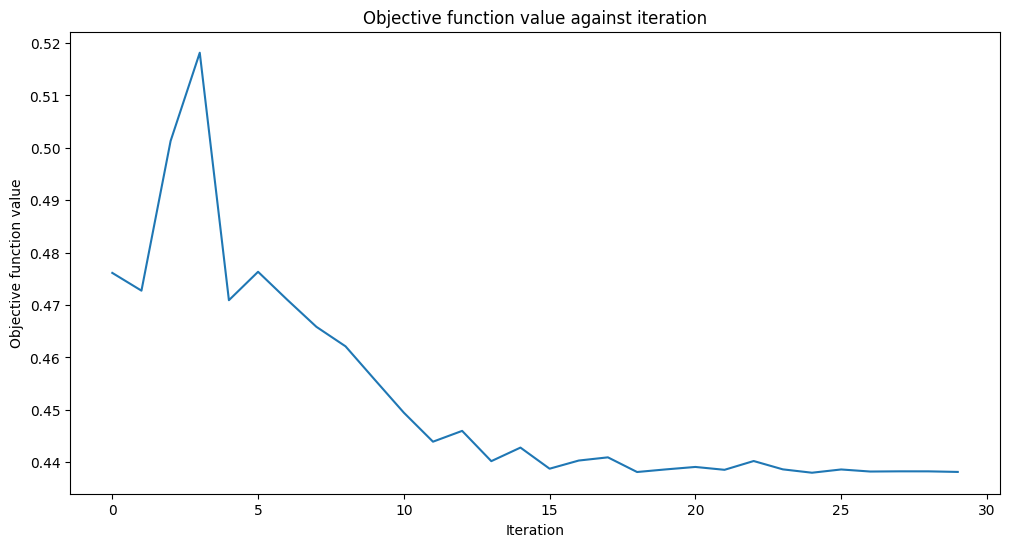

Training complete. Training time:  346.909964799881
Testing... [[77 67]
 [71 85]]
Testing complete. Testing time:  10.365548610687256
Accuracy:  0.54
Precision:  0.5397403982930299
Recall:  0.5397970085470085
F1:  0.5396726561110122



In [158]:
objective_func_vals = []
toy = 0
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_10_1, toy=toy, write_scores=True)

In [159]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.6375
Number of weights: 4, normalized effective dimension: 0.9094
Normalized local effective dimensions for trained QNN:  -0.44912699110766846


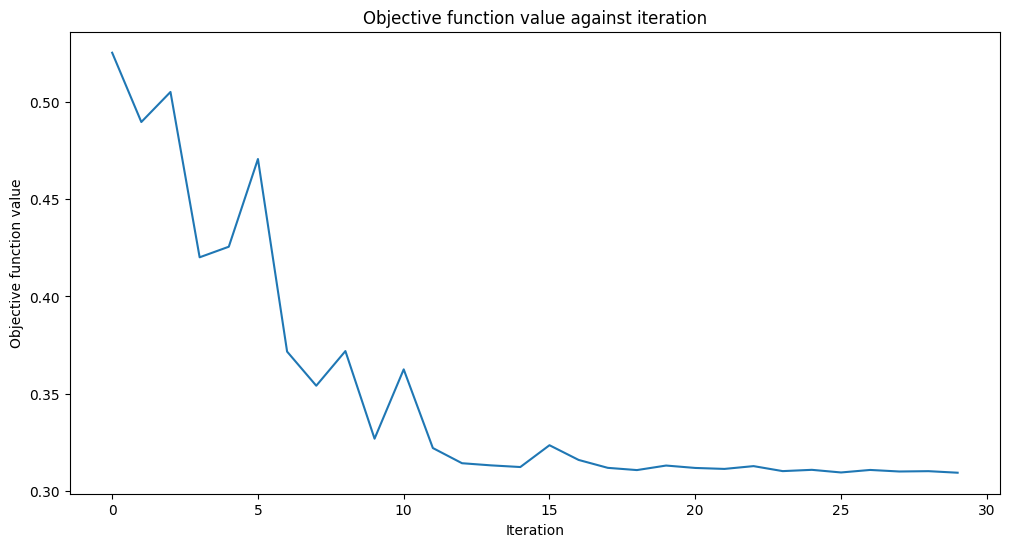

Training complete. Training time:  448.60772919654846
Testing... [[156   0]
 [ 46  98]]
Testing complete. Testing time:  9.759787797927856
Accuracy:  0.8466666666666667
Precision:  0.8861386138613861
Recall:  0.8402777777777778
F1:  0.8407128676300845



In [160]:
objective_func_vals = []
toy = 0
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_11_1, toy=toy, write_scores=True)

In [161]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.6750
Number of weights: 4, normalized effective dimension: 0.9188
Normalized local effective dimensions for trained QNN:  -0.39061010809554775


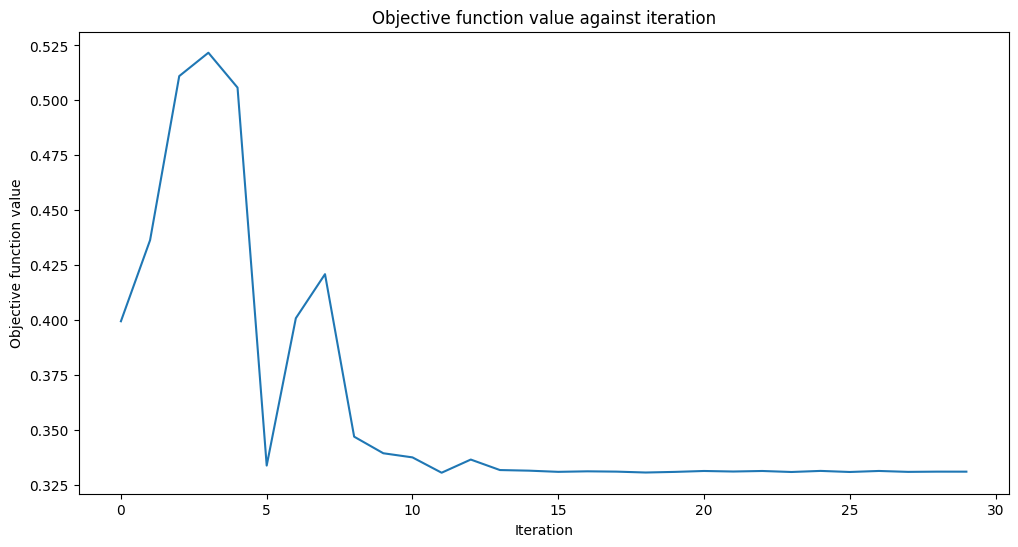

Training complete. Training time:  334.59153270721436
Testing... [[102  38]
 [ 34 126]]
Testing complete. Testing time:  8.65390920639038
Accuracy:  0.76
Precision:  0.7591463414634146
Recall:  0.7580357142857143
F1:  0.7584541062801932



In [162]:
objective_func_vals = []
toy = 0
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_12_1, toy=toy, write_scores=True)

In [163]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.6307
Number of weights: 4, normalized effective dimension: 0.9077
Normalized local effective dimensions for trained QNN:  -0.45247921526853857


## Toy data 1

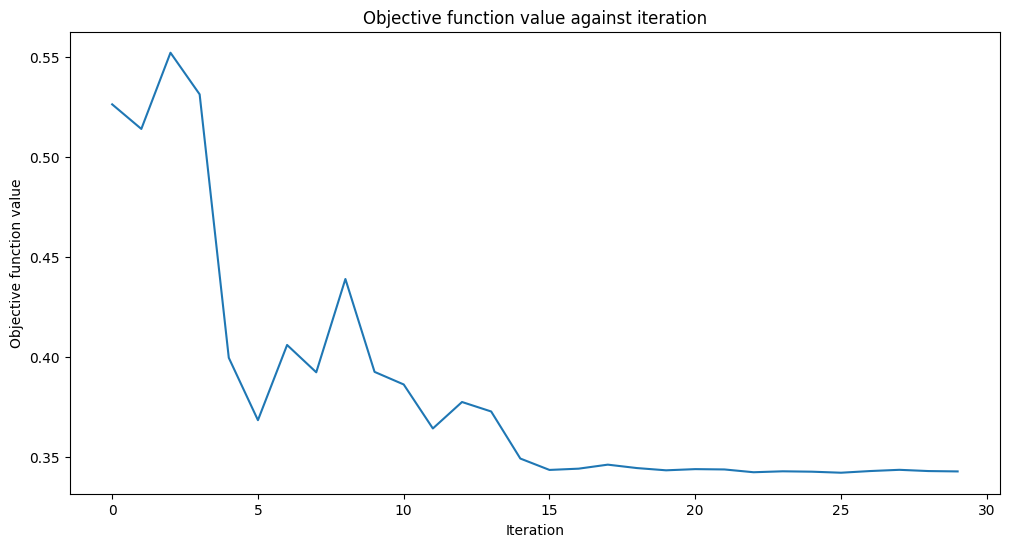

Training complete. Training time:  569.1517279148102
Testing... [[ 63  46]
 [ 11 180]]
Testing complete. Testing time:  28.652913808822632
Accuracy:  0.81
Precision:  0.8239057641712508
Recall:  0.7601950141697488
F1:  0.77591697134096



In [110]:
objective_func_vals = []
toy = 1
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_8_1, toy=toy, write_scores=True)

In [111]:
qnn_ged(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.3562
Number of weights: 4, normalized effective dimension: 0.8390


In [112]:
qnn_led(wts, nnc, dataset, toy)

Normalized local effective dimensions for trained QNN:  -0.43306147203848316


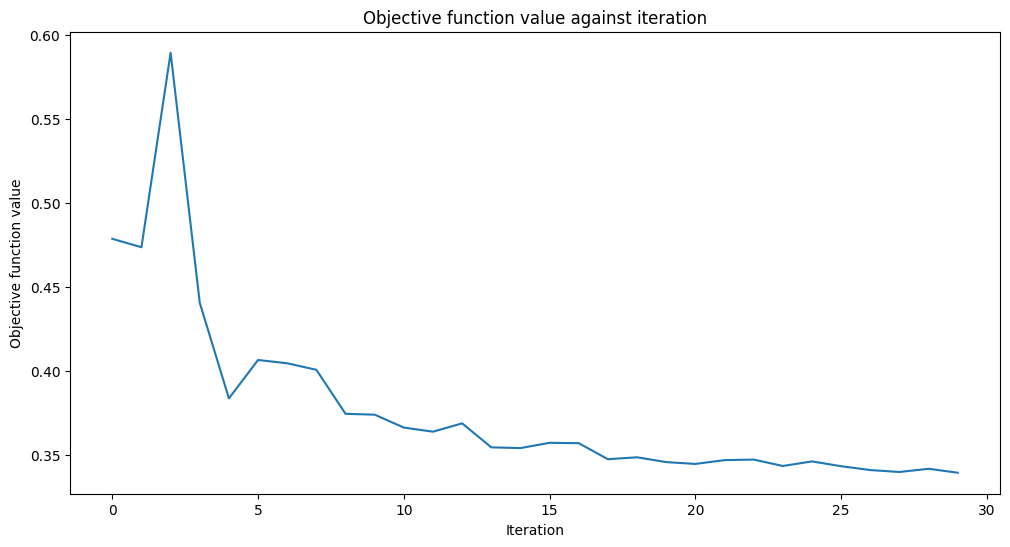

Training complete. Training time:  555.3688831329346
Testing... [[ 97  25]
 [ 15 163]]
Testing complete. Testing time:  12.081726312637329
Accuracy:  0.8666666666666667
Precision:  0.8665463525835866
Recall:  0.8554061521458832
F1:  0.8598851057867452



In [114]:
objective_func_vals = []
toy = 1
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_9_1, toy=toy, write_scores=True)

In [115]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.3665
Number of weights: 4, normalized effective dimension: 0.8416
Normalized local effective dimensions for trained QNN:  -0.42538502598678196


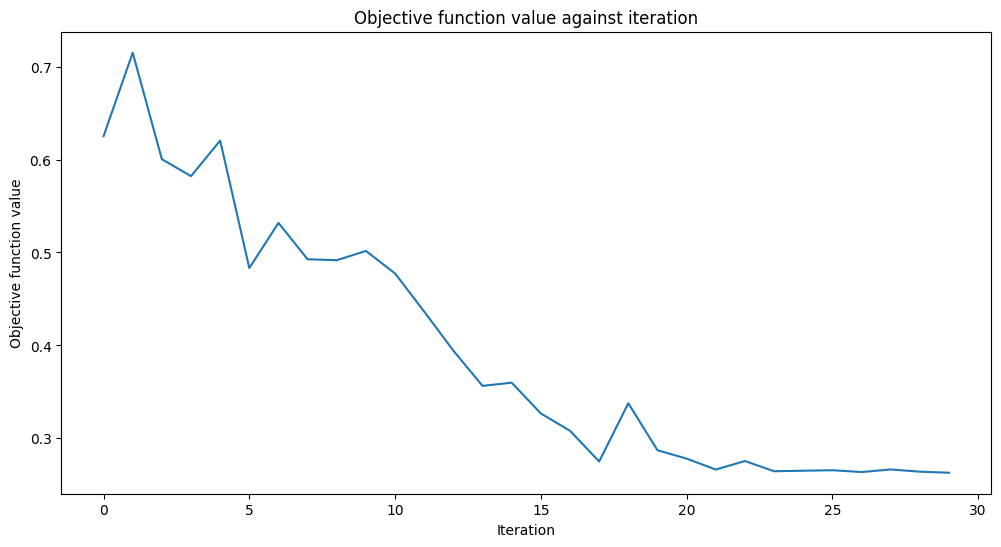

Training complete. Training time:  621.9309811592102
Testing... [[119   6]
 [ 29 146]]
Testing complete. Testing time:  17.911896467208862
Accuracy:  0.8833333333333333
Precision:  0.8822901849217639
Recall:  0.8931428571428571
F1:  0.8823806163255705



In [116]:
objective_func_vals = []
toy = 1
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_10_1, toy=toy, write_scores=True)

In [117]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.5763
Number of weights: 4, normalized effective dimension: 0.8941
Normalized local effective dimensions for trained QNN:  -0.4515980151830463


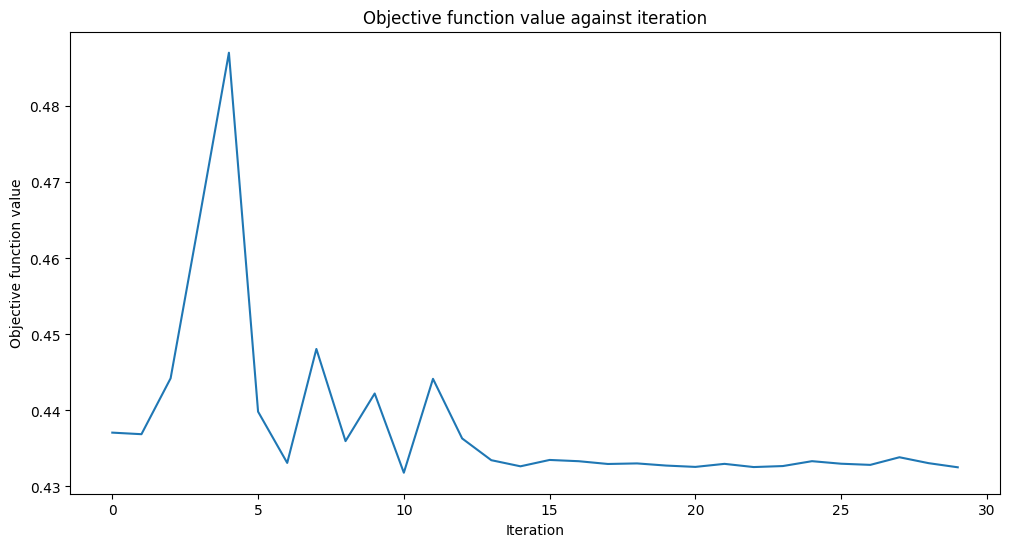

Training complete. Training time:  593.5736467838287
Testing... [[  0 106]
 [  0 194]]
Testing complete. Testing time:  16.309333562850952
Accuracy:  0.6466666666666666
Precision:  0.3233333333333333
Recall:  0.5
F1:  0.39271255060728744



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [118]:
objective_func_vals = []
toy = 1
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_11_1, toy=toy, write_scores=True)

In [120]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.0176
Number of weights: 4, normalized effective dimension: 0.7544
Normalized local effective dimensions for trained QNN:  -0.4000919405952474


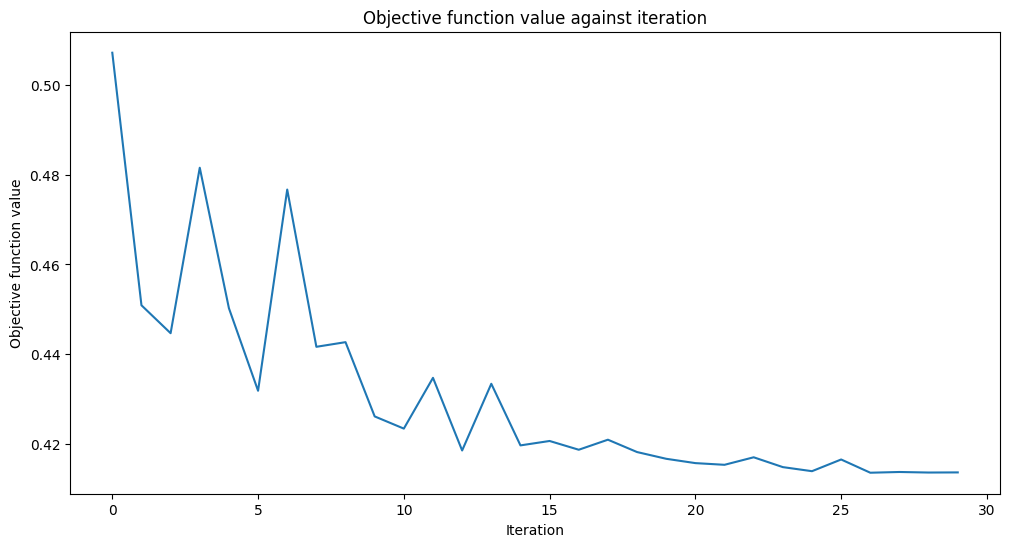

Training complete. Training time:  586.5748121738434
Testing... [[ 55  56]
 [ 58 131]]
Testing complete. Testing time:  15.189565896987915
Accuracy:  0.62
Precision:  0.5936302115375515
Recall:  0.5943085943085943
F1:  0.5939399696048632



In [121]:
objective_func_vals = []
toy = 1
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_12_1, toy=toy, write_scores=True)

In [122]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.5928
Number of weights: 4, normalized effective dimension: 0.8982
Normalized local effective dimensions for trained QNN:  -0.45598097602906174


## Toy data 2

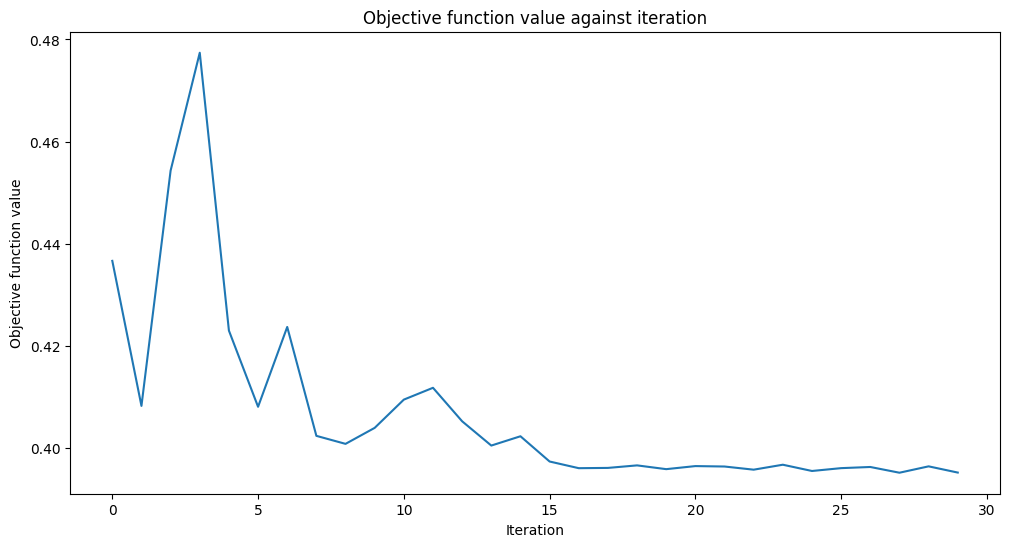

Training complete. Training time:  599.8716351985931
Testing... [[165  28]
 [ 79  28]]
Testing complete. Testing time:  17.754327297210693
Accuracy:  0.6433333333333333
Precision:  0.5881147540983607
Recall:  0.5583022613917001
F1:  0.5493535118136766



In [123]:
objective_func_vals = []
toy = 2
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_8_1, toy=toy, write_scores=True)

In [124]:
qnn_ged(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.4786
Number of weights: 4, normalized effective dimension: 0.8696


In [125]:
qnn_led(wts, nnc, dataset, toy)

Normalized local effective dimensions for trained QNN:  -0.4331656597084701


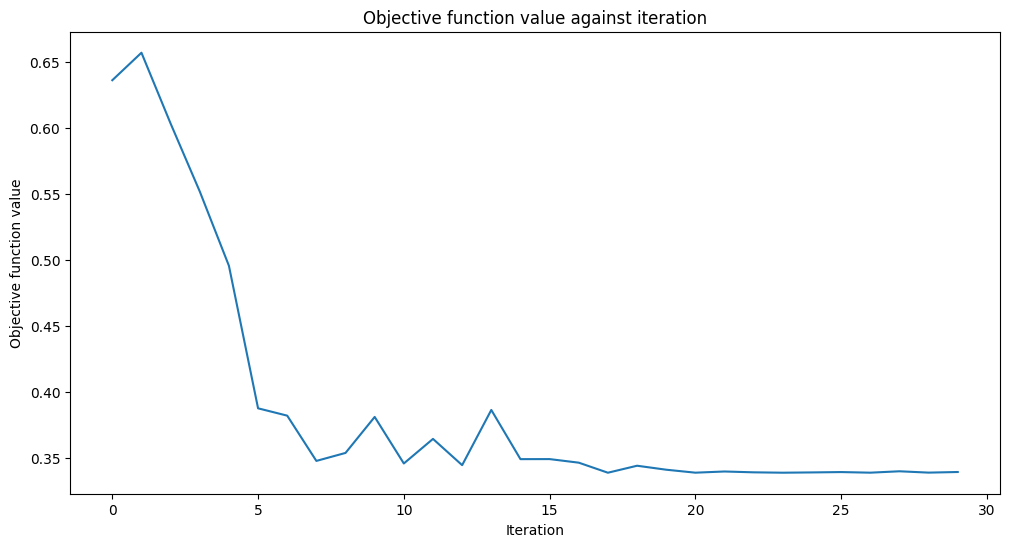

Training complete. Training time:  603.0100486278534
Testing... [[203   5]
 [ 89   3]]
Testing complete. Testing time:  17.111900568008423
Accuracy:  0.6866666666666666
Precision:  0.5351027397260274
Recall:  0.5042851170568562
F1:  0.43599999999999994



In [126]:
objective_func_vals = []
toy = 2
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_9_1, toy=toy, write_scores=True)

In [127]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.3706
Number of weights: 4, normalized effective dimension: 0.8426
Normalized local effective dimensions for trained QNN:  -0.4542479416942688


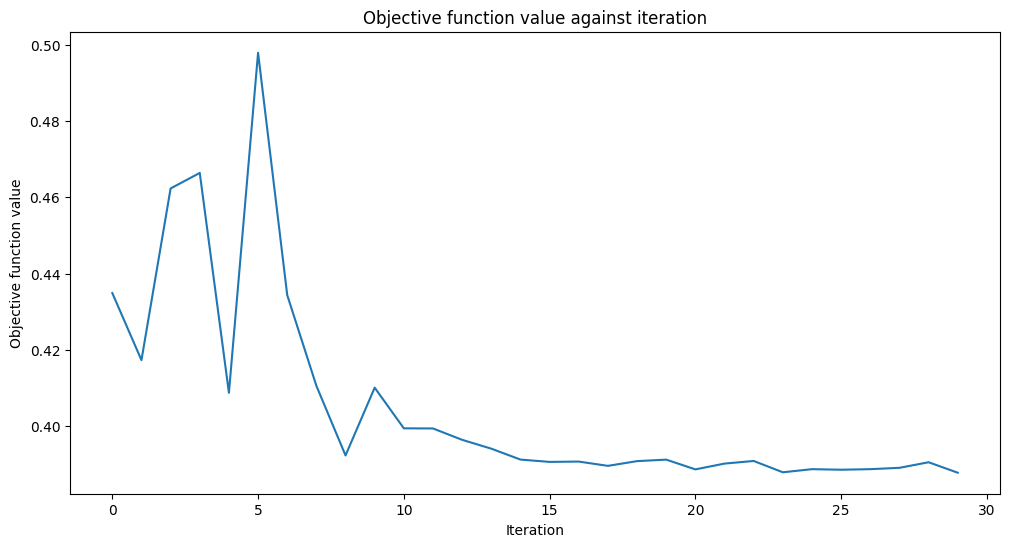

Training complete. Training time:  360.06548142433167
Testing... [[137  50]
 [ 55  58]]
Testing complete. Testing time:  12.18349814414978
Accuracy:  0.65
Precision:  0.6252893518518519
Recall:  0.6229473285694005
F1:  0.6239210114733938



In [128]:
objective_func_vals = []
toy = 2
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_10_1, toy=toy, write_scores=True)

In [129]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.6166
Number of weights: 4, normalized effective dimension: 0.9041
Normalized local effective dimensions for trained QNN:  -0.44363662675667864


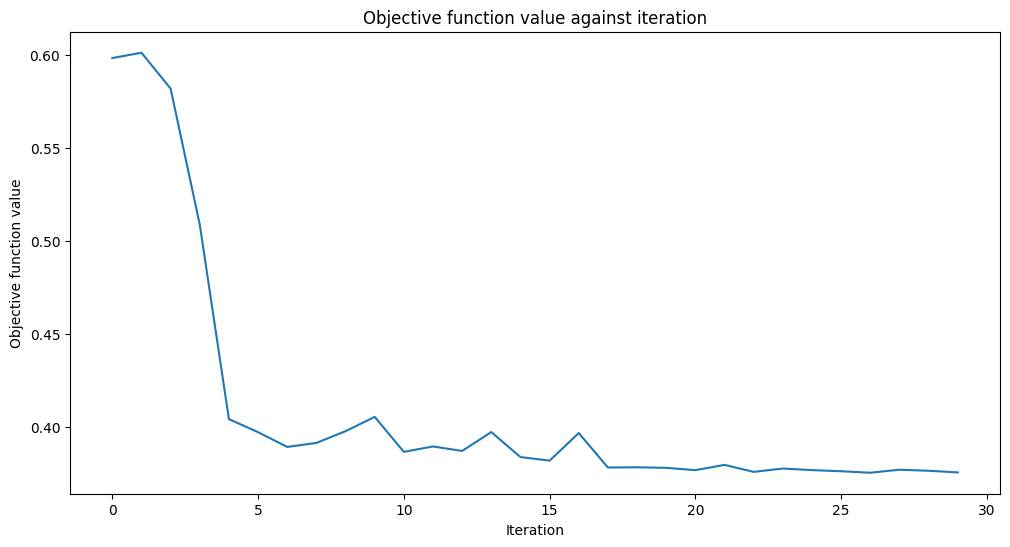

Training complete. Training time:  471.8675982952118
Testing... [[200   2]
 [ 98   0]]
Testing complete. Testing time:  9.550499200820923
Accuracy:  0.6666666666666666
Precision:  0.33557046979865773
Recall:  0.49504950495049505
F1:  0.4000000000000001



In [130]:
objective_func_vals = []
toy = 2
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_11_1, toy=toy, write_scores=True)

In [131]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.8625
Number of weights: 4, normalized effective dimension: 0.9656
Normalized local effective dimensions for trained QNN:  -0.41785879952618027


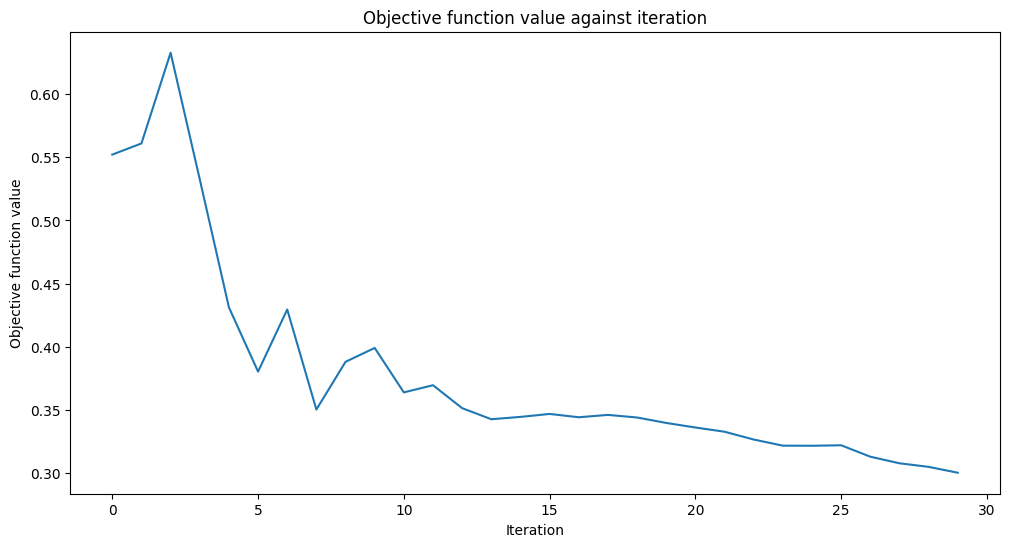

Training complete. Training time:  392.12903118133545
Testing... [[156  37]
 [ 21  86]]
Testing complete. Testing time:  11.772032260894775
Accuracy:  0.8066666666666666
Precision:  0.7902714620366542
Recall:  0.806014236598712
F1:  0.7955346650998825



In [132]:
objective_func_vals = []
toy = 2
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_12_1, toy=toy, write_scores=True)

In [133]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 3.4527
Number of weights: 4, normalized effective dimension: 0.8632
Normalized local effective dimensions for trained QNN:  -0.4726711179814586


## Toy data 3

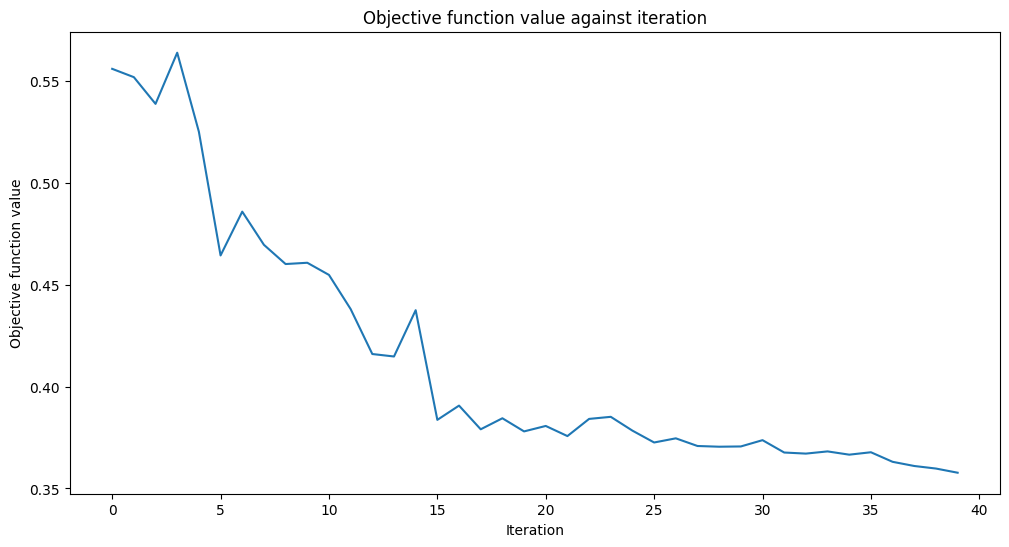

Training complete. Training time:  592.4949414730072
Testing... [[165  52]
 [  9  74]]
Testing complete. Testing time:  16.116090536117554
Accuracy:  0.7966666666666666
Precision:  0.7677887246852764
Recall:  0.8259674643273556
F1:  0.776061870556419



In [136]:
objective_func_vals = []
toy = 3
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_8_1, toy=toy, write_scores=True)

In [137]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 4.5931
Number of weights: 6, normalized effective dimension: 0.7655
Normalized local effective dimensions for trained QNN:  -0.38338916179041066


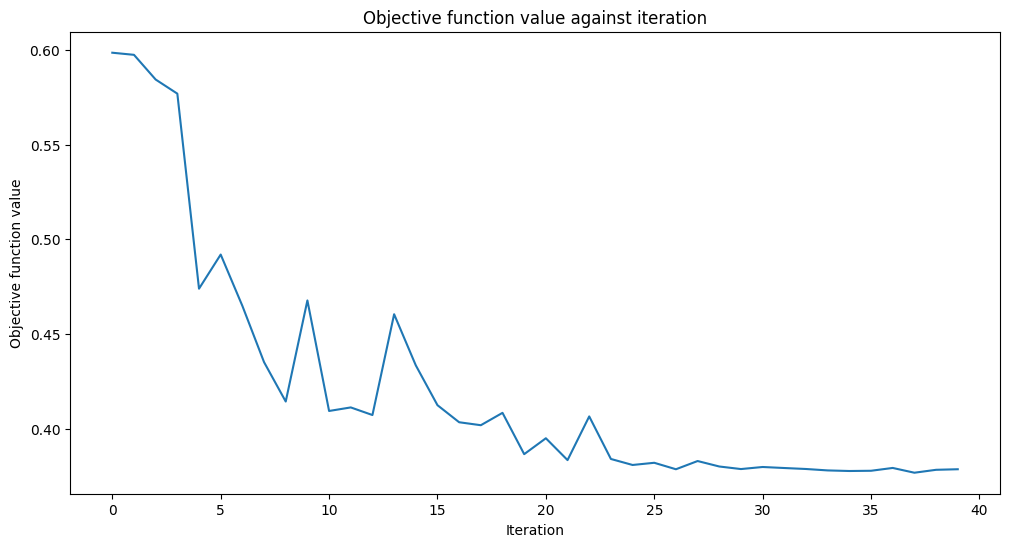

Training complete. Training time:  687.8279767036438
Testing... [[185  40]
 [ 31  44]]
Testing complete. Testing time:  13.26554012298584
Accuracy:  0.7633333333333333
Precision:  0.6901455026455027
Recall:  0.7044444444444444
F1:  0.6962306935352756



In [138]:
objective_func_vals = []
toy = 3
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_9_1, toy=toy, write_scores=True)

In [139]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 5.1903
Number of weights: 6, normalized effective dimension: 0.8651
Normalized local effective dimensions for trained QNN:  -0.4030781597072139


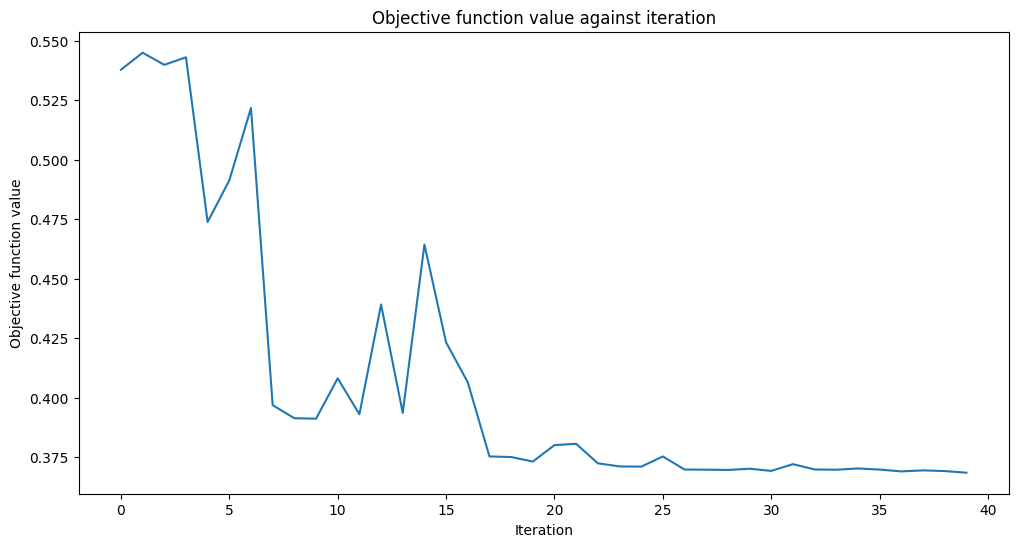

Training complete. Training time:  666.2020370960236
Testing... [[168  42]
 [ 54  36]]
Testing complete. Testing time:  14.883183240890503
Accuracy:  0.68
Precision:  0.6091476091476091
Recall:  0.6000000000000001
F1:  0.6031746031746031



In [140]:
objective_func_vals = []
toy = 3
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_10_1, toy=toy, write_scores=True)

In [141]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 5.1598
Number of weights: 6, normalized effective dimension: 0.8600
Normalized local effective dimensions for trained QNN:  -0.31547256917499655


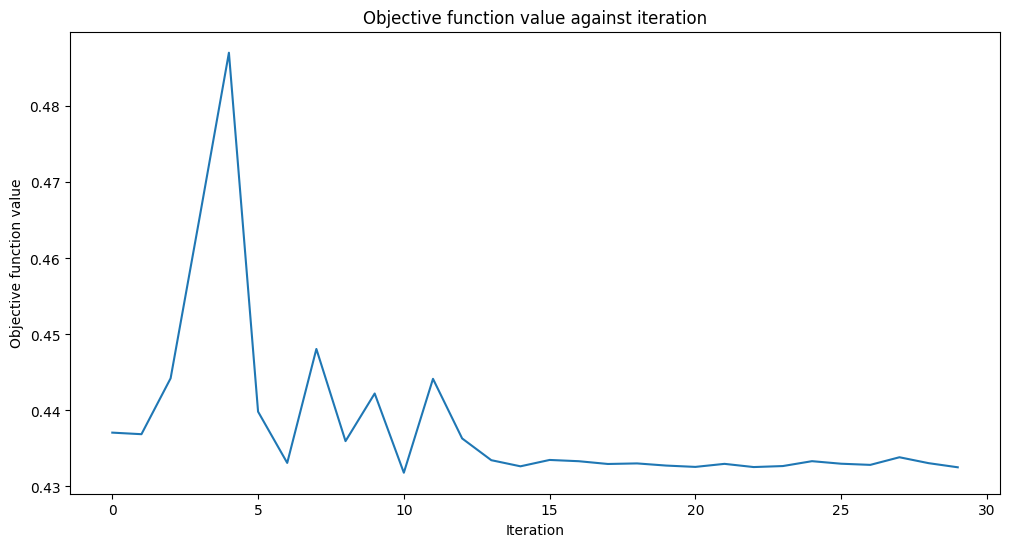

Training complete. Training time:  593.5736467838287
Testing... [[  0 106]
 [  0 194]]
Testing complete. Testing time:  16.309333562850952
Accuracy:  0.6466666666666666
Precision:  0.3233333333333333
Recall:  0.5
F1:  0.39271255060728744



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
objective_func_vals = []
toy = 3
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_11_1, toy=toy, write_scores=True)

In [142]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 5.2634
Number of weights: 6, normalized effective dimension: 0.8772
Normalized local effective dimensions for trained QNN:  -0.3154050019595277


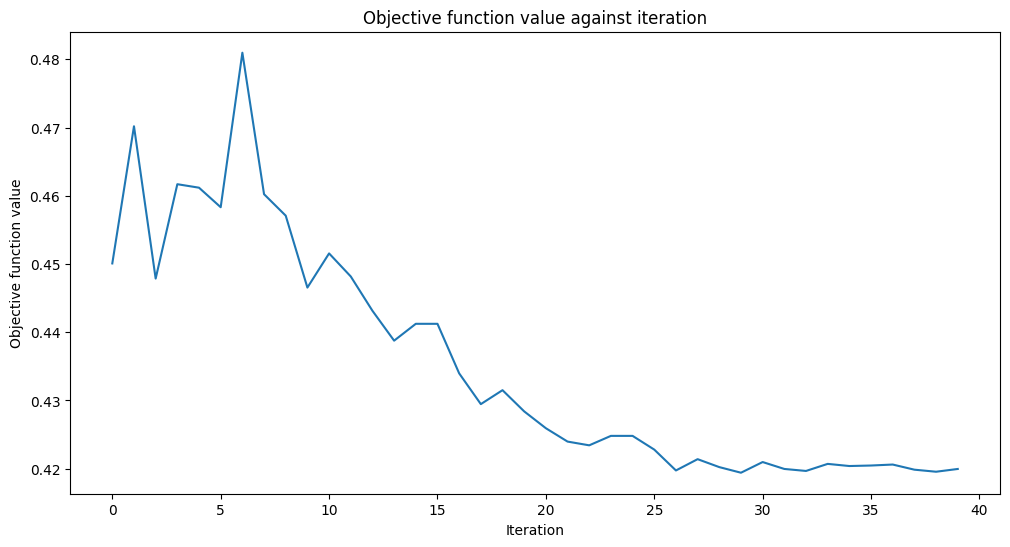

Training complete. Training time:  553.708564043045
Testing... [[172  48]
 [ 35  45]]
Testing complete. Testing time:  13.972875118255615
Accuracy:  0.7233333333333334
Precision:  0.6573944210690355
Recall:  0.6721590909090909
F1:  0.6629259113860649



In [143]:
objective_func_vals = []
toy = 3
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_12_1, toy=toy, write_scores=True)

In [144]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 5.3597
Number of weights: 6, normalized effective dimension: 0.8933
Normalized local effective dimensions for trained QNN:  -0.4152485747176425


## Toy data 4

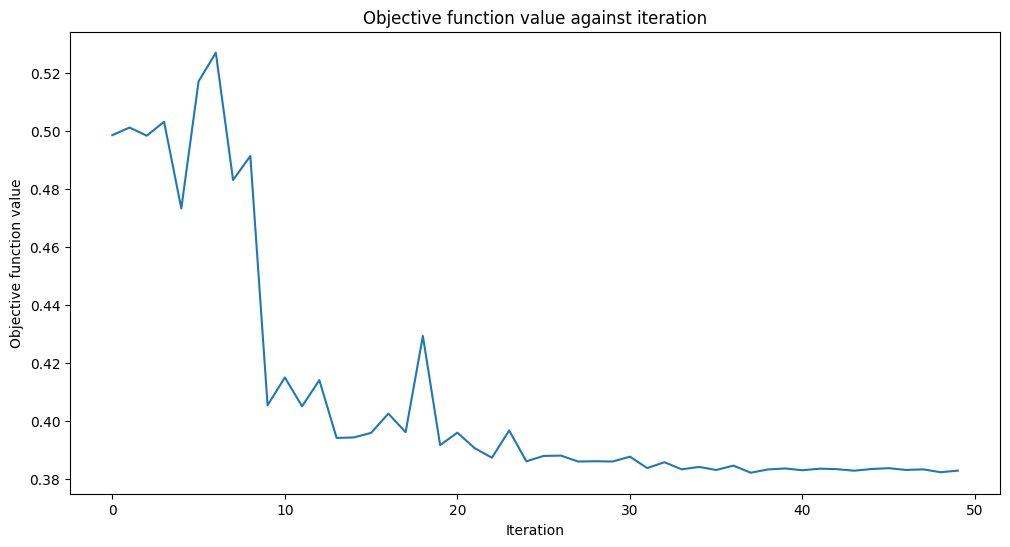

Training complete. Training time:  909.6440274715424
Testing... [[ 87  51]
 [ 32 130]]
Testing complete. Testing time:  15.240821361541748
Accuracy:  0.7233333333333334
Precision:  0.7246622405868425
Recall:  0.7164519592055825
F1:  0.7175301471338953



In [165]:
objective_func_vals = []
toy = 4
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_8_1, toy=toy, write_scores=True)

In [166]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 6.7327
Number of weights: 8, normalized effective dimension: 0.8416
Normalized local effective dimensions for trained QNN:  -0.4063248345058301


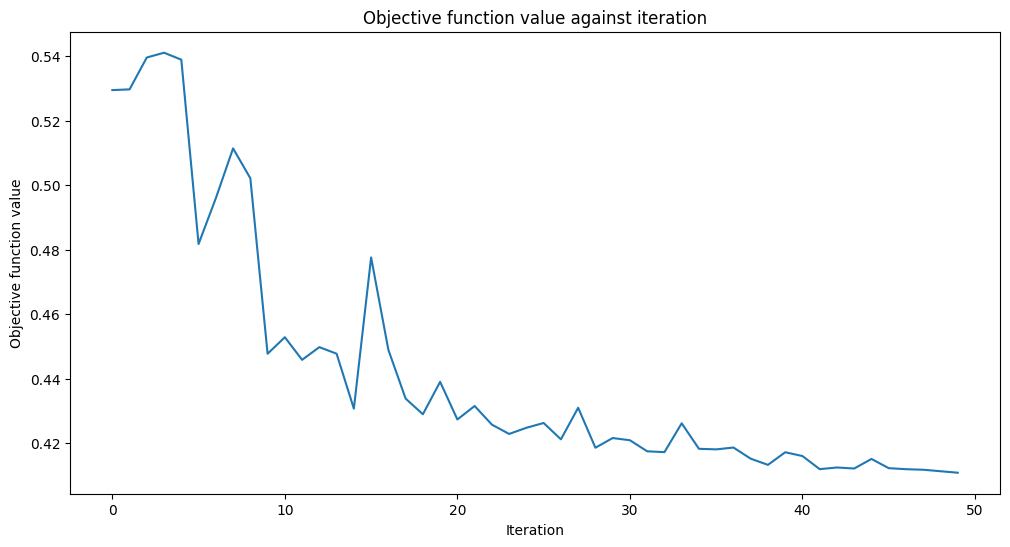

Training complete. Training time:  1049.3574125766754
Testing... [[122  22]
 [ 69  87]]
Testing complete. Testing time:  18.10441756248474
Accuracy:  0.6966666666666667
Precision:  0.7184542965560305
Recall:  0.7024572649572649
F1:  0.6924809912700647



In [167]:
objective_func_vals = []
toy = 4
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_9_1, toy=toy, write_scores=True)

In [168]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 6.6556
Number of weights: 8, normalized effective dimension: 0.8319
Normalized local effective dimensions for trained QNN:  -0.411035732342132


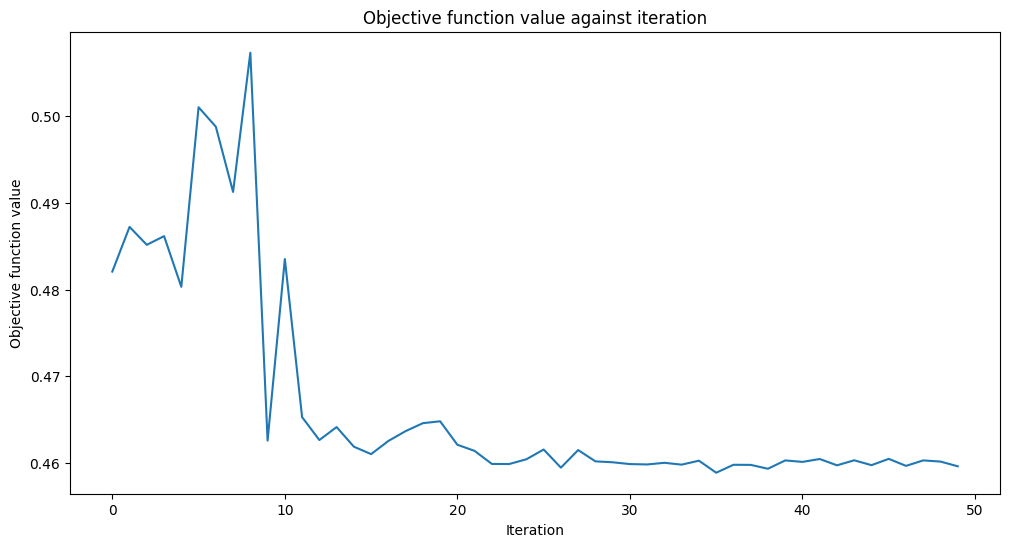

Training complete. Training time:  1237.01336145401
Testing... [[ 35  98]
 [ 34 133]]
Testing complete. Testing time:  15.747405052185059
Accuracy:  0.56
Precision:  0.541501976284585
Recall:  0.5297825401827922
F1:  0.50743818100403



In [169]:
objective_func_vals = []
toy = 4
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_10_1, toy=toy, write_scores=True)

In [170]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 6.7765
Number of weights: 8, normalized effective dimension: 0.8471
Normalized local effective dimensions for trained QNN:  -0.3898202228753797


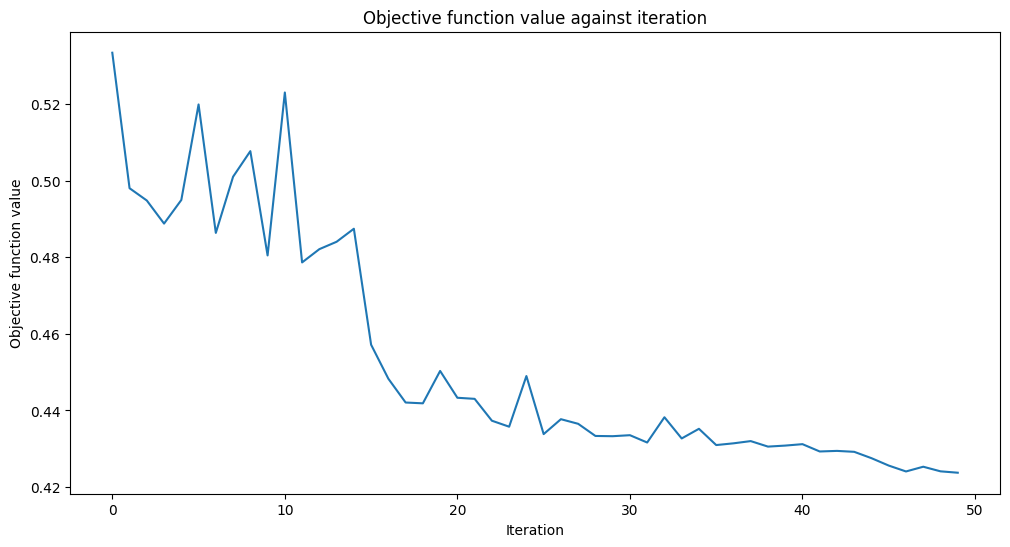

Training complete. Training time:  1165.3131129741669
Testing... [[102  33]
 [ 50 115]]
Testing complete. Testing time:  21.05819869041443
Accuracy:  0.7233333333333334
Precision:  0.7240398293029872
Recall:  0.7262626262626263
F1:  0.7228128374391913



In [171]:
objective_func_vals = []
toy = 4
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_11_1, toy=toy, write_scores=True)

In [172]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 6.6699
Number of weights: 8, normalized effective dimension: 0.8337
Normalized local effective dimensions for trained QNN:  -0.40601353837942533


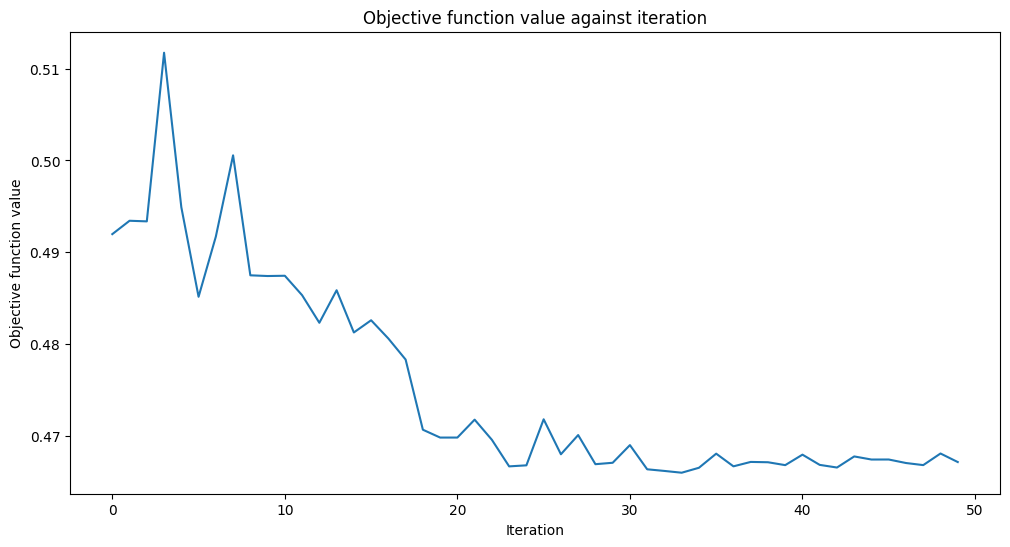

Training complete. Training time:  1040.3951661586761
Testing... [[88 47]
 [66 99]]
Testing complete. Testing time:  16.868807554244995
Accuracy:  0.6233333333333333
Precision:  0.6247553816046967
Recall:  0.625925925925926
F1:  0.6228262441727211



In [173]:
objective_func_vals = []
toy = 4
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_12_1, toy=toy, write_scores=True)

In [174]:
qnn_ged(wts, nnc, dataset, toy)
qnn_led(wts, nnc, dataset, toy)

Data size: 300, global effective dimension: 6.6162
Number of weights: 8, normalized effective dimension: 0.8270
Normalized local effective dimensions for trained QNN:  -0.46912008213580625
